In [1]:
##################
# IMPORT LIBRARIES
##################

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings('ignore')

- **'id'** = interaction id
- **'Customer ID'** = UNIQUE CUSTOMER ID *unique = 19976 / value_counts.sum = 19976 / 17, 12, 8, 7, 7....*
- 'Customer Name' = PROBLEM multiple customer name of a single customer ID
*unique = 17738 / value_counts.sum = 20443 / 33, 17, 11, 11, 9.....*
- 'Customer Description' = Migration or special Gifted Status
- 'Plan' = plan_1 = 20442 / plan_2 = 1
- 'Product' = Supper Club = 20442 / renew test = 1
- 'Interval' = year = 20442 / day = 1
- 'Amount' = 69 = 20442 / 1 = 1
- **'status'** = 'trialing', 'active', 'canceled', 'past_due', 'incomplete_expired'
- **'Created'** = interaction date *'Created (UTC)' is the first date in all rows: True*
- **'kind (metadata)'** = Migrated OG Member 552
- **''Cancel At Period End'** = False : 16878 / True : 3565





In [2]:
##################
# VISUAL SETTINGS
##################

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

In [3]:
##################
# LOADING CSV
##################

RENAME_FILES = False
data_dir = 'data'

files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
]

sorted_files = sorted(files, key=os.path.getctime, reverse=True)

for file_path in sorted_files:
    created_at = datetime.fromtimestamp(os.path.getctime(file_path))
    timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
    original_name = os.path.basename(file_path)
    new_name = f"{timestamp_str}_{original_name}"
    new_path = os.path.join(data_dir, new_name)

    if RENAME_FILES:
        if not original_name.startswith(timestamp_str):
            os.rename(file_path, new_path)
            print(f"Renamed: {original_name} → {new_name}")
            file_path = new_path
        else:
            print(f"Already renamed: {original_name}")
    else:
        print(f"[DEV] Would rename: {original_name} → {new_name}")

df_raw = pd.read_csv(file_path)

[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-29_18-44-09_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv


In [4]:
##################
# DATA PREPROCESSING
##################

df = df_raw.copy()

# Date conversion
date_cols = [col for col in df.columns if '(UTC)' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)#.dt.strftime('%d/%m/%y %H:%M')

df = df.sort_values(by='Created (UTC)')

# Column selection and renaming
df = df[['Customer ID', 'Customer Name', 'Status', 'Cancellation Reason',
         'Created (UTC)', 'Start (UTC)', 'Start Date (UTC)', 'Current Period Start (UTC)',
         'Current Period End (UTC)', 'Trial Start (UTC)', 'Trial End (UTC)',
         'Canceled At (UTC)', 'Ended At (UTC)', 'senderShopifyCustomerId (metadata)']]

df.rename(columns={
    'Customer ID': 'customer_id',
    'Customer Name': 'customer_name',
    'Status': 'status',
    'Created (UTC)': 'created_utc',
    'Start (UTC)': 'start_utc',
    'Start Date (UTC)': 'start_date_utc',
    'Current Period Start (UTC)': 'current_period_start_utc',
    'Current Period End (UTC)': 'current_period_end_utc',
    'Trial Start (UTC)': 'trial_start_utc',
    'Trial End (UTC)': 'trial_end_utc',
    'Canceled At (UTC)': 'canceled_at_utc',
    'Ended At (UTC)': 'ended_at_utc',
    'senderShopifyCustomerId (metadata)': 'is_gifted_member'
}, inplace=True)

# Convert is_gifted_member to boolean
df['is_gifted_member'] = df['is_gifted_member'].notna()

#reference_date = datetime.now(pytz.UTC)
# TODAY DATE
reference_date = pd.Timestamp.now(tz='UTC')#.strftime('%d/%m/%y %H:%M')

# Consolidate status
df.loc[df['status'].isin(['past_due', 'incomplete_expired']), 'status'] = 'canceled'

In [5]:
##################
# HELPER FUNCTIONS
##################

def clean_membership_data(df):
    """Clean and prepare membership data for analysis"""
    # Remove very short subscriptions
    df['duration_days'] = (pd.to_datetime(df['ended_at_utc']) - pd.to_datetime(df['created_utc'])).dt.days
    df_clean = df[~((df['duration_days'] < 1) & (df['duration_days'].notna()))]
    
    # Remove duplicate signups (within 6 hours)
    df_clean = df_clean.sort_values(['customer_name', 'created_utc'])
    df_clean['time_diff'] = df_clean.groupby('customer_name')['created_utc'].diff()
    df_clean = df_clean[~((df_clean['time_diff'] < pd.Timedelta(hours=6)) & (df_clean['time_diff'].notna()))]
    
    return df_clean.drop(['duration_days', 'time_diff'], axis=1)



# def validate_conversion_funnel(customer_df):
#     """Validate funnel consistency"""
#     total_signups = len(customer_df)
#     initial_conversions = customer_df['paid_after_trial'].sum()
#     eligible_renewals = customer_df['eligible_for_1st_renewal'].sum()
#     actual_renewals = customer_df['actually_renewed_1st'].sum()
#     actual_renewals_2nd = customer_df['actually_renewed_2nd'].sum()
    
#     print("=== VALIDATION DU FUNNEL ===")
#     print(f"Signups totaux: {total_signups:,}")
#     print(f"Conversions initiales: {initial_conversions:,}")
#     print(f"Éligibles renouvellement: {eligible_renewals:,}")
#     print(f"Renouvellements réels: {actual_renewals:,}")
#     print(f"Renouvellements réels 2nd: {actual_renewals_2nd:,}")
    
#     assert actual_renewals <= eligible_renewals, "Plus de renouvellements que d'éligibles!"
#     assert eligible_renewals <= initial_conversions, "Plus d'éligibles que de conversions!"
#     assert initial_conversions <= total_signups, "Plus de conversions que de signups!"
    
#     print("✓ Cohérence du funnel validée")
#     return {
#         'signups': total_signups,
#         'conversions': initial_conversions,
#         'eligible_renewals': eligible_renewals,
#         'actual_renewals': actual_renewals
#     }

# def calculate_subscription_duration(row):
#     """Calculate subscription duration accurately"""
#     start_date = row['trial_end_utc'] if pd.notna(row['trial_end_utc']) else row['created_utc']
    
#     if row['status'] == 'active':
#         end_date = reference_date
#     elif pd.notna(row['canceled_at_utc']):
#         end_date = row['canceled_at_utc']
#     elif pd.notna(row['ended_at_utc']):
#         end_date = row['ended_at_utc']
#     else:
#         end_date = reference_date
    
#     return (end_date - start_date).days

# def calculate_subscription_duration(row):
#     """Calculate subscription duration accurately"""
#     start_date = row['current_period_start_utc']
    
#     if pd.notna(row['canceled_at_utc']):
#         # Si l'abonnement est annulé, utiliser ended_at_utc
#         end_date = row['ended_at_utc']
#     else:
#         # Si l'abonnement n'est pas annulé, utiliser current_period_end_utc
#         end_date = row['current_period_end_utc']
    
#     return (end_date - start_date).days

def calculate_real_duration(row):
    """Calculate subscription duration accurately"""
    start_date = row['current_period_start_utc']

    if pd.notna(row['ended_at_utc']):
        end_date = row['ended_at_utc']
    else:
        end_date = row['current_period_end_utc']
    
    return (end_date - start_date).days


def calculate_period_duration(row):
    """Calculate subscription duration accurately"""
    start_date = row['current_period_start_utc']
    end_date = row['current_period_end_utc']
    
    return (end_date - start_date).days

def calculate_trial_duration(row):
    """Calculate subscription duration accurately"""
    start_date = row['trial_start_utc']
    end_date = row['trial_end_utc']
    
    return (end_date - start_date).days


In [6]:
##################
# DATA PROCESSING
##################

#df = clean_membership_data(df)
print(f"📅 Reference date (TODAY) for analysis: {reference_date.strftime('%d-%m-%Y')}")

# Filter to regular signups only
# analysis_df = df[~df['is_gifted_member']].copy()

# Unfiltered
analysis_df = df.copy()

# Cleaning Abnormal Date
analysis_df = clean_membership_data(analysis_df)

# Customer currently trialing
analysis_df['is_currently_trialing'] = analysis_df['status'] == 'trialing'

# Real duration of subscription 
analysis_df['real_duration'] = analysis_df.apply(calculate_real_duration, axis=1)

# Duration of the selected period
analysis_df['period_duration'] = analysis_df.apply(calculate_period_duration, axis=1)

# Duration of trial
analysis_df['unknown_period'] = (analysis_df['current_period_start_utc'] - analysis_df['created_utc']).dt.days

analysis_df['trial_duration'] = analysis_df.apply(calculate_trial_duration, axis=1)
analysis_df['only_trial'] = analysis_df['period_duration'] == analysis_df['trial_duration']

# Define conversion logic
# analysis_df['paid_after_trial'] = (
#     ((analysis_df['status'] == 'active') & analysis_df['canceled_at_utc'].isna()) |
#     ((analysis_df['status'] == 'canceled') & (analysis_df['canceled_at_utc'].notna()) & 
#      (analysis_df['trial_end_utc'].notna()) & 
#      (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc'] + pd.Timedelta(days=14))) |
#     ((analysis_df['status'] == 'canceled') & (analysis_df['canceled_at_utc'].notna()) & 
#      (analysis_df['trial_end_utc'].isna()) & (analysis_df['current_period_start_utc'].notna()) & 
#      (analysis_df['current_period_end_utc'].notna()) &
#      ((analysis_df['current_period_end_utc'] - analysis_df['current_period_start_utc']).dt.days > 50))
# )
# analysis_df['paid_after_trial'] = (
#     (analysis_df['status'] == 'active') |
#     ((analysis_df['status'] == 'canceled') &
#      (analysis_df['only_trial'] == False) &
#      (analysis_df['canceled_at_utc'].notna()) & 
#      (analysis_df['trial_end_utc'].notna()) & 
#      (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc'] + pd.Timedelta(days=14)))
# )

analysis_df['paid_after_trial'] = (
    (analysis_df['status'] == 'active') |
    ((analysis_df['status'] == 'canceled') &
     (analysis_df['only_trial'] == False) &
     (analysis_df['canceled_at_utc'].isna())) |
     ((analysis_df['status'] == 'canceled') &
     (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc'])))


analysis_df['cancel_during_trial'] = (
    ((analysis_df['status'] == 'canceled') &
      (analysis_df['canceled_at_utc'] <= analysis_df['trial_end_utc'])) |
      ((analysis_df['status'] == 'trialing') & 
       (analysis_df['canceled_at_utc'] <= analysis_df['trial_end_utc']))
)


# analysis_df['is_trial_cancellation'] = (
#     ((analysis_df['status'] == 'canceled') & (analysis_df['trial_end_utc'].notna()) & 
#      (analysis_df['canceled_at_utc'].notna()) & 
#      (analysis_df['canceled_at_utc'] <= analysis_df['trial_end_utc'])) |
#     ((analysis_df['status'] == 'canceled') & (analysis_df['trial_end_utc'].isna()) & 
#      (analysis_df['canceled_at_utc'].notna()))
# )

analysis_df['was_refund'] = (
    (analysis_df['status'] == 'canceled') & 
    (analysis_df['only_trial'] == False) &
    (analysis_df['cancel_during_trial'] == False) & 
    (analysis_df['canceled_at_utc'] < analysis_df['trial_end_utc'] + pd.Timedelta(days=14)) &
    (analysis_df['real_duration'] >= analysis_df['trial_duration'])
)


# analysis_df['is_refund'] = (
#     (analysis_df['status'] == 'canceled') & (analysis_df['canceled_at_utc'].notna()) &
#     (analysis_df['trial_end_utc'].notna()) & 
#     (analysis_df['canceled_at_utc'] > analysis_df['trial_end_utc']) &
#     ((analysis_df['canceled_at_utc'] - analysis_df['trial_end_utc']).dt.days <= 14)
# )

analysis_df['in_churn_period'] = (
    ((analysis_df['status'] == 'active') &
     (analysis_df['trial_end_utc'] + pd.Timedelta(days=14) >= reference_date)) |
    ((analysis_df['status'] == 'active') &
     (analysis_df['current_period_start_utc'] + pd.Timedelta(days=14) >= reference_date))
)

analysis_df['end_soon'] = (
    (analysis_df['status'] == 'active') &
    (analysis_df['current_period_end_utc'] + pd.Timedelta(days=14) >= reference_date) &
    (analysis_df['current_period_end_utc'] > reference_date)
)

📅 Reference date (TODAY) for analysis: 29-05-2025


In [8]:
#analysis_df['real_duration'].value_counts()
#analysis_df[analysis_df['end_soon'] == True]
#analysis_df['real_duration'].value_counts().head(30)
#analysis_df[analysis_df['real_duration'] == 1]

analysis_df.drop(columns=['customer_id', 'Cancellation Reason'], inplace=True)
analysis_df[analysis_df['was_refund'] == True]
#analysis_df[analysis_df['ended_at_utc'].isna()]['status'].value_counts()
#analysis_df


#POURQUOI SONT IL CONSIDERER REMBOURSÉ

,customer_name,status,created_utc,start_utc,start_date_utc,current_period_start_utc,current_period_end_utc,trial_start_utc,trial_end_utc,canceled_at_utc,...,real_duration,period_duration,unknown_period,trial_duration,only_trial,paid_after_trial,cancel_during_trial,was_refund,in_churn_period,end_soon
11676,Customer10011,canceled,2024-04-02 18:32:00+00:00,2024-04-02 18:32:00+00:00,2024-04-02 18:32:00+00:00,2024-04-12 18:32:00+00:00,2025-04-12 18:32:00+00:00,2024-04-02 18:32:00+00:00,2024-04-12 18:32:00+00:00,2024-04-25 11:42:00+00:00,...,12,365,10,10.0,False,True,False,True,False,False
11513,Customer10309,canceled,2024-04-09 17:10:00+00:00,2024-04-09 17:10:00+00:00,2024-04-09 17:10:00+00:00,2024-04-19 17:10:00+00:00,2025-04-19 17:10:00+00:00,2024-04-09 17:10:00+00:00,2024-04-19 17:10:00+00:00,2024-04-30 07:18:00+00:00,...,10,365,10,10.0,False,True,False,True,False,False
11634,Customer10411,canceled,2024-04-03 18:07:00+00:00,2024-04-16 14:03:00+00:00,2024-04-03 18:07:00+00:00,2024-04-13 18:07:00+00:00,2025-04-13 18:07:00+00:00,2024-04-03 18:07:00+00:00,2024-04-13 18:07:00+00:00,2024-04-16 14:03:00+00:00,...,365,365,10,10.0,False,True,False,True,False,False
1130,Customer1070,canceled,2025-04-01 17:12:00+00:00,2025-04-01 17:12:00+00:00,2025-04-01 17:12:00+00:00,2025-04-11 17:12:00+00:00,2026-04-11 17:12:00+00:00,2025-04-01 17:12:00+00:00,2025-04-11 17:12:00+00:00,2025-04-24 07:57:00+00:00,...,12,365,10,10.0,False,True,False,True,False,False
12501,Customer11110,canceled,2024-03-04 09:15:00+00:00,2024-03-14 10:21:00+00:00,2024-03-04 09:15:00+00:00,2024-03-14 09:15:00+00:00,2025-03-14 09:15:00+00:00,2024-03-04 09:15:00+00:00,2024-03-14 09:15:00+00:00,2024-03-14 10:21:00+00:00,...,365,365,10,10.0,False,True,False,True,False,False
12601,Customer11198,canceled,2024-03-01 10:59:00+00:00,2024-03-01 10:59:00+00:00,2024-03-01 10:59:00+00:00,2024-03-11 10:59:00+00:00,2025-03-11 10:59:00+00:00,2024-03-01 10:59:00+00:00,2024-03-11 10:59:00+00:00,2024-03-22 08:38:00+00:00,...,10,365,10,10.0,False,True,False,True,False,False
12719,Customer11303,canceled,2024-02-27 20:50:00+00:00,2024-02-27 20:50:00+00:00,2024-02-27 20:50:00+00:00,2024-03-08 20:50:00+00:00,2025-03-08 20:50:00+00:00,2024-02-27 20:50:00+00:00,2024-03-08 20:50:00+00:00,2024-03-22 08:39:00+00:00,...,13,365,10,10.0,False,True,False,True,False,False
13612,Customer12047,canceled,2024-02-08 16:52:00+00:00,2024-02-08 16:52:00+00:00,2024-02-08 16:52:00+00:00,2024-02-18 16:52:00+00:00,2025-02-18 16:52:00+00:00,2024-02-08 16:52:00+00:00,2024-02-18 16:52:00+00:00,2024-03-02 13:36:00+00:00,...,12,366,10,10.0,False,True,False,True,False,False
13965,Customer12344,canceled,2024-02-06 07:13:00+00:00,2024-02-16 08:57:00+00:00,2024-02-06 07:13:00+00:00,2024-02-16 07:13:00+00:00,2025-02-16 07:13:00+00:00,2024-02-06 07:13:00+00:00,2024-02-16 07:13:00+00:00,2024-02-16 08:57:00+00:00,...,366,366,10,10.0,False,True,False,True,False,False
14736,Customer12994,canceled,2024-01-25 13:25:00+00:00,2024-02-13 13:53:00+00:00,2024-01-25 13:25:00+00:00,2024-02-04 13:25:00+00:00,2025-02-04 13:25:00+00:00,2024-01-25 13:25:00+00:00,2024-02-04 13:25:00+00:00,2024-02-13 13:53:00+00:00,...,366,366,10,10.0,False,True,False,True,False,False


In [316]:
# # migrated = df_raw[df_raw['kind (metadata)'].notna()]
# # print(f"MIGRATED\nStart on {migrated['Start (UTC)'].min()}\nEnd in : {migrated['Start (UTC)'].max()}")
# # print("---------------------------------")
# # print(f"REGULAR\nStart on {analysis_df['start_utc'].min()}\nEnd in : {analysis_df['start_utc'].max()}")
# # print("---------------------------------")

# #analysis_df['subscription_duration'].tail(20)
# # analysis_df.tail(20)
# # analysis_df[analysis_df['customer_name'] == 'Customer12']
# # df[df['customer_id'] == 'cus_OnERK20W7y40xE']
# #analysis_df[analysis_df['subscription_duration'] > 300]['customer_name'].value_counts()
# # Customer5019
# # Customer8877
# # Customer13370
# # Customer10190
# # Customer1778

# analysis_df.drop(columns=['id'], inplace=True)

# # #analysis_df['subscription_duration'].value_counts().head(20)
# # analysis_df[analysis_df['subscription_duration'] > 38]['customer_name'].value_counts()
# # analysis_df[analysis_df['customer_name']== 'Customer8878']

# # analysis_df['len_of_trial'] = (analysis_df['trial_end_utc'] - analysis_df['trial_start_utc']).dt.days
# # analysis_df['len_of_trial'].value_counts()
# # len_df = analysis_df[(analysis_df['len_of_trial'] != 10.0) & (analysis_df['len_of_trial'] != 30.0) & (analysis_df['len_of_trial'] != 0.0) & (analysis_df['len_of_trial'].notna())]
# # print(len_df['created_utc'].min().strftime('%d/%m/%y'), '>', len_df['created_utc'].max().strftime('%d/%m/%y'))
# # len_df.head(30)

# # analysis_df[analysis_df['only_trial'] == False]
# # analysis_df[analysis_df['ended_at_utc'].notna()]
# # analysis_df[analysis_df['ended_at_utc'].isna() & (analysis_df['status'] == 'canceled')]

# analysis_df[analysis_df['unknown_period'] != 0]
# analysis_df[analysis_df['customer_name']== 'Customer13510']

# analysis_df[(analysis_df['status'] != 'active') & (analysis_df['ended_at_utc'].isna())]
# analysis_df[analysis_df['status'] == 'past_due']['unknown_period'].value_counts()
# analysis_df[(analysis_df['status'] != 'active') & (analysis_df['unknown_period'] == 252)]

In [317]:
##################
# CUSTOMER AGGREGATION
##################

customer_df = analysis_df.groupby('customer_name').agg({
    'customer_id': 'first',
    'created_utc': 'first',
    'status': 'last',
    'current_period_start_utc': 'last',
    'current_period_end_utc': 'last',
    'trial_start_utc': 'first',
    'trial_end_utc': 'first',
    'canceled_at_utc': 'last',
    'ended_at_utc': 'last',
    'is_gifted_member': 'any',
    'paid_after_trial': 'any',
    'is_trial_cancellation': 'any',
    'is_refund': 'any',
    'is_currently_trialing': 'any',
    'subscription_duration': 'sum',
    'id': 'count'
}).rename(columns={'id': 'subscription_count'}).reset_index()

# Remove gifted members
# customer_df = customer_df[customer_df['is_gifted_member'] == False]


# Calculate subscription duration for each customer
#customer_df['subscription_duration_days'] = customer_df.apply(calculate_subscription_duration, axis=1)


# Define customer-level metrics
customer_df['subscription_start_date'] = np.where(
    customer_df['trial_end_utc'].notna(),
    customer_df['trial_end_utc'],
    customer_df['created_utc']
)

# customer_df['eligible_for_1st_renewal'] = (
#     customer_df['paid_after_trial'] & 
#     (customer_df['subscription_duration_days'] >= 300)
# )

# customer_df['actually_renewed_1st'] = (
#     customer_df['paid_after_trial'] & 
#     (customer_df['subscription_duration_days'] >= 400)
# )

# customer_df['actually_renewed_2nd'] = (
#     customer_df['paid_after_trial'] & 
#     (customer_df['subscription_duration_days'] >= 730)
# )


customer_df['eligible_for_1st_renewal'] = (
    customer_df['paid_after_trial'] & 
    (customer_df['subscription_duration'] >= 300)
)

customer_df['actually_renewed_1st'] = (
    customer_df['paid_after_trial'] & 
    (customer_df['subscription_duration'] >= 400)
)

customer_df['actually_renewed_2nd'] = (
    customer_df['paid_after_trial'] & 
    (customer_df['subscription_duration'] >= 730)
)

KeyError: "Column(s) ['customer_id', 'id', 'is_refund', 'is_trial_cancellation', 'subscription_duration'] do not exist"

In [512]:
##################
# STATUS DETERMINATION
##################

def determine_customer_status(row):
    if row['is_trial_cancellation']:
        return 'Trial Canceled'
    elif row['is_currently_trialing']:
        return 'Trialing'
    elif not row['paid_after_trial']:
        return 'Never Converted'
    elif row['actually_renewed_1st'] and row['status'] in ['active', 'past_due']:
        return 'Active - Renewed'
    elif row['paid_after_trial'] and row['status'] in ['active', 'past_due']:
        return 'Active - First Year'
    else:
        return 'Churned'

customer_df['current_status_agg'] = customer_df.apply(determine_customer_status, axis=1)

In [513]:
customer_df['paid_after_trial'] = (
    (
        (customer_df['status'] == 'active') & customer_df['canceled_at_utc'].isna()
    ) |
    (
        (customer_df['status'] == 'canceled') &
        (customer_df['canceled_at_utc'].notna()) &
        (customer_df['trial_end_utc'].notna()) &
        (customer_df['canceled_at_utc'] > customer_df['trial_end_utc'] + pd.Timedelta(days=14))
    ) |
    (
        (customer_df['status'] == 'canceled') &
        (customer_df['canceled_at_utc'].notna()) &
        (customer_df['trial_end_utc'].isna()) &
        (customer_df['current_period_start_utc'].notna()) &
        (customer_df['current_period_end_utc'].notna()) &
        ((customer_df['current_period_end_utc'] - customer_df['current_period_start_utc']).dt.days > 50)
    )
)

customer_df['is_trial_cancellation'] = (
    (customer_df['status'] == 'canceled') &
    (customer_df['canceled_at_utc'].notna()) &
    (
        (customer_df['trial_end_utc'].notna() & 
         (customer_df['canceled_at_utc'] <= customer_df['trial_end_utc'])) |
        (customer_df['trial_end_utc'].isna())
    )
)

customer_df['is_refund'] = (
    (customer_df['status'] == 'canceled') & 
    (customer_df['canceled_at_utc'].notna()) &
    (customer_df['trial_end_utc'].notna()) &
    (customer_df['canceled_at_utc'] > customer_df['trial_end_utc']) &
    ((customer_df['canceled_at_utc'] - customer_df['trial_end_utc']).dt.days <= 14)
)

customer_df['is_currently_trialing'] = customer_df['status'] == 'trialing'

customer_df['subscription_start_date'] = np.where(
    customer_df['trial_end_utc'].notna(),
    customer_df['trial_end_utc'],
    customer_df['created_utc']
)

# Customer-level metrics finaux
customer_df['paid_initial_subscription'] = customer_df['paid_after_trial']
customer_df['trial_canceled'] = customer_df['is_trial_cancellation'] 
customer_df['refunded_initial'] = customer_df['is_refund']
customer_df['currently_trialing'] = customer_df['is_currently_trialing']
customer_df['first_subscription_start_date'] = customer_df['subscription_start_date']

In [514]:
##################
# KPI CALCULATIONS
##################

total_unique_signups = len(customer_df)
total_initial_conversions = customer_df['paid_after_trial'].sum()
total_trial_cancellations = customer_df['is_trial_cancellation'].sum()
total_refunded = customer_df['is_refund'].sum()
total_eligible_for_renewal = customer_df['eligible_for_1st_renewal'].sum()
total_actually_renewed = customer_df['actually_renewed_1st'].sum()
current_active_members = customer_df[customer_df['status'] == 'active']['customer_name'].nunique()

# Validate funnel
funnel_metrics = validate_conversion_funnel(customer_df)

# Calculate rates
kpi_conversion_rate = (total_initial_conversions / total_unique_signups * 100) if total_unique_signups > 0 else 0
kpi_trial_cancel_rate = (total_trial_cancellations / total_unique_signups * 100) if total_unique_signups > 0 else 0
kpi_refund_rate = (total_refunded / total_initial_conversions * 100) if total_initial_conversions > 0 else 0
kpi_renewal_rate = (total_actually_renewed / total_eligible_for_renewal * 100) if total_eligible_for_renewal > 0 else 0

=== VALIDATION DU FUNNEL ===
Signups totaux: 16,881
Conversions initiales: 6,955
Éligibles renouvellement: 6,788
Renouvellements réels: 322
Renouvellements réels 2nd: 37
✓ Cohérence du funnel validée


In [515]:
##################
# RESULTS SUMMARY
##################

print(f"Total unique non-gift signups: {total_unique_signups:,}")
print(f"Total unique initial conversions: {total_initial_conversions:,}")
print(f"Currently active paying members: {current_active_members:,}")
print(f"Initial conversion rate: {kpi_conversion_rate:.1f}%")
print(f"Trial cancellation rate: {kpi_trial_cancel_rate:.1f}%")
print(f"Refund rate (on initial conversions): {kpi_refund_rate:.1f}%")
print(f"Customers eligible for 1st renewal: {total_eligible_for_renewal:,}")
print(f"Customers who actually renewed 1st time: {total_actually_renewed:,}")
print(f"Renewal rate (on eligible): {kpi_renewal_rate:.1f}%")

Total unique non-gift signups: 16,881
Total unique initial conversions: 6,955
Currently active paying members: 5,824
Initial conversion rate: 41.2%
Trial cancellation rate: 47.2%
Refund rate (on initial conversions): 14.6%
Customers eligible for 1st renewal: 6,788
Customers who actually renewed 1st time: 322
Renewal rate (on eligible): 4.7%


In [516]:
##################
# COHORT ANALYSIS
##################

customer_df['signup_week'] = customer_df['created_utc'].dt.to_period('W-SUN')

cohort_analysis_df = customer_df.groupby('signup_week').agg(
    total_signups_cohort=('customer_name', 'nunique'),
    initial_conversions_cohort=('paid_after_trial', 'sum'),
    trial_cancellations_cohort=('is_trial_cancellation', 'sum'),
    refunds_cohort=('is_refund', 'sum'),
    eligible_for_renewal_cohort=('eligible_for_1st_renewal', 'sum'),
    actually_renewed_cohort=('actually_renewed_1st', 'sum')
).reset_index()

# Calculate cohort rates
cohort_analysis_df['conversion_rate_cohort'] = np.where(
    cohort_analysis_df['total_signups_cohort'] > 0,
    (cohort_analysis_df['initial_conversions_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['trial_cancel_rate_cohort'] = np.where(
    cohort_analysis_df['total_signups_cohort'] > 0,
    (cohort_analysis_df['trial_cancellations_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['refund_rate_cohort'] = np.where(
    cohort_analysis_df['initial_conversions_cohort'] > 0,
    (cohort_analysis_df['refunds_cohort'] / cohort_analysis_df['initial_conversions_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['renewal_rate_cohort'] = np.where(
    cohort_analysis_df['eligible_for_renewal_cohort'] > 0,
    (cohort_analysis_df['actually_renewed_cohort'] / cohort_analysis_df['eligible_for_renewal_cohort'] * 100),
    0
).round(1)

In [517]:
##################
# VISUALIZATIONS
##################

def create_improved_visualizations():
    """Creates visualizations with corrected logic"""
    
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Dishpatch Supper Club - Overall Business Metrics', 
                  fontsize=20, fontweight='bold')

    # Conversion Funnel
    funnel_stages = ['Unique\nSignups', 'Initial\nNet Conversions', 'Currently\nActive', 'Renewed\n(1st Time)']
    funnel_counts = [total_unique_signups, total_initial_conversions, current_active_members, total_actually_renewed]
    funnel_colors = ['#4a7bab', '#69a760', '#f08c4c', '#c45d5d']

    bars = ax1.bar(funnel_stages, funnel_counts, color=funnel_colors)
    ax1.set_title('Conversion Funnel (Unique Customers)', fontweight='bold')
    ax1.set_ylabel('Number of Customers')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / funnel_counts[0] * 100) if funnel_counts[0] > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 * max(funnel_counts)), 
                 f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.set_ylim(0, max(funnel_counts) * 1.15)

    # Status Distribution
    status_counts_agg = customer_df['current_status_agg'].value_counts()
    colors = plt.cm.viridis(np.linspace(0, 1, len(status_counts_agg)))
    
    wedges, texts, autotexts = ax2.pie(status_counts_agg.values, labels=status_counts_agg.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90, pctdistance=0.85)
    ax2.set_title('Current Status Distribution (Unique Customers)', fontweight='bold')
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    # Key Business KPIs
    kpi_names = ['Initial\nConversion Rate', 'Trial\nCancellation Rate', 'Refund Rate\n(on Conversions)', 'Renewal Rate\n(1st Time)']
    kpi_values = [kpi_conversion_rate, kpi_trial_cancel_rate, kpi_refund_rate, kpi_renewal_rate]
    kpi_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    
    kpi_bars = ax3.bar(kpi_names, kpi_values, color=kpi_colors)
    ax3.set_title('Key Performance Indicators (KPIs)', fontweight='bold')
    ax3.set_ylabel('Rate (%)')
    
    for bar in kpi_bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
                 ha='center', va='bottom', fontweight='bold')
    ax3.set_ylim(0, max(kpi_values) * 1.2 if kpi_values else 10)

    # Simple member count over time
    ax4.text(0.5, 0.5, f"Current Active Members:\n{current_active_members:,}", 
             ha='center', va='center', transform=ax4.transAxes, fontsize=16, fontweight='bold')
    ax4.set_title('Active Members Summary', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [518]:
# Cohort Analysis Visualization
def create_cohort_analysis():
    recent_cohorts = cohort_analysis_df.tail(26).copy()
    recent_cohorts['cohort_week_str'] = recent_cohorts['signup_week'].astype(str)

    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    fig2.suptitle('Weekly Cohort Analysis (Last 26 Weeks)', fontsize=20, fontweight='bold')
    x_pos_cohort = np.arange(len(recent_cohorts))

    # Signups vs Conversions
    ax1.bar(x_pos_cohort - 0.2, recent_cohorts['total_signups_cohort'], width=0.4, label='Signups', color='#3498db', alpha=0.8)
    ax1.bar(x_pos_cohort + 0.2, recent_cohorts['initial_conversions_cohort'], width=0.4, label='Initial Conversions', color='#2ecc71', alpha=0.8)
    ax1.set_title('Signups vs Initial Conversions by Cohort', fontweight='bold')
    ax1.set_ylabel('Number of Customers')
    ax1.set_xticks(x_pos_cohort)
    ax1.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax1.legend()

    # Rates
    ax2.plot(x_pos_cohort, recent_cohorts['conversion_rate_cohort'], linewidth=2, color='#2ecc71', marker='o', label='Initial Conversion Rate')
    ax2.plot(x_pos_cohort, recent_cohorts['trial_cancel_rate_cohort'], linewidth=2, color='#e74c3c', marker='s', label="Trial Cancellation Rate")
    ax2.set_title('Conversion and Trial Cancellation Rates by Cohort', fontweight='bold')
    ax2.set_ylabel('Rate (%)')
    ax2.set_xticks(x_pos_cohort)
    ax2.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax2.legend()

    # Refund Rate
    ax3.bar(x_pos_cohort, recent_cohorts['refund_rate_cohort'], color='#f39c12', alpha=0.8)
    ax3.set_title('Refund Rate by Cohort', fontweight='bold')
    ax3.set_ylabel('Refund Rate (%)')
    ax3.set_xticks(x_pos_cohort)
    ax3.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)

    # Renewal Rate
    mature_cohorts = recent_cohorts[recent_cohorts['eligible_for_renewal_cohort'] > 0]
    if not mature_cohorts.empty:
        x_pos_renewal = np.arange(len(mature_cohorts))
        ax4.bar(x_pos_renewal, mature_cohorts['renewal_rate_cohort'], color='#9b59b6', alpha=0.8)
        ax4.set_xticks(x_pos_renewal)
        ax4.set_xticklabels(mature_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    else:
        ax4.text(0.5, 0.5, "No mature cohorts\nfor renewal analysis", 
                 ha='center', va='center', transform=ax4.transAxes, fontsize=12)

    ax4.set_title('Renewal Rate by Mature Cohort', fontweight='bold')
    ax4.set_ylabel('Renewal Rate (%)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

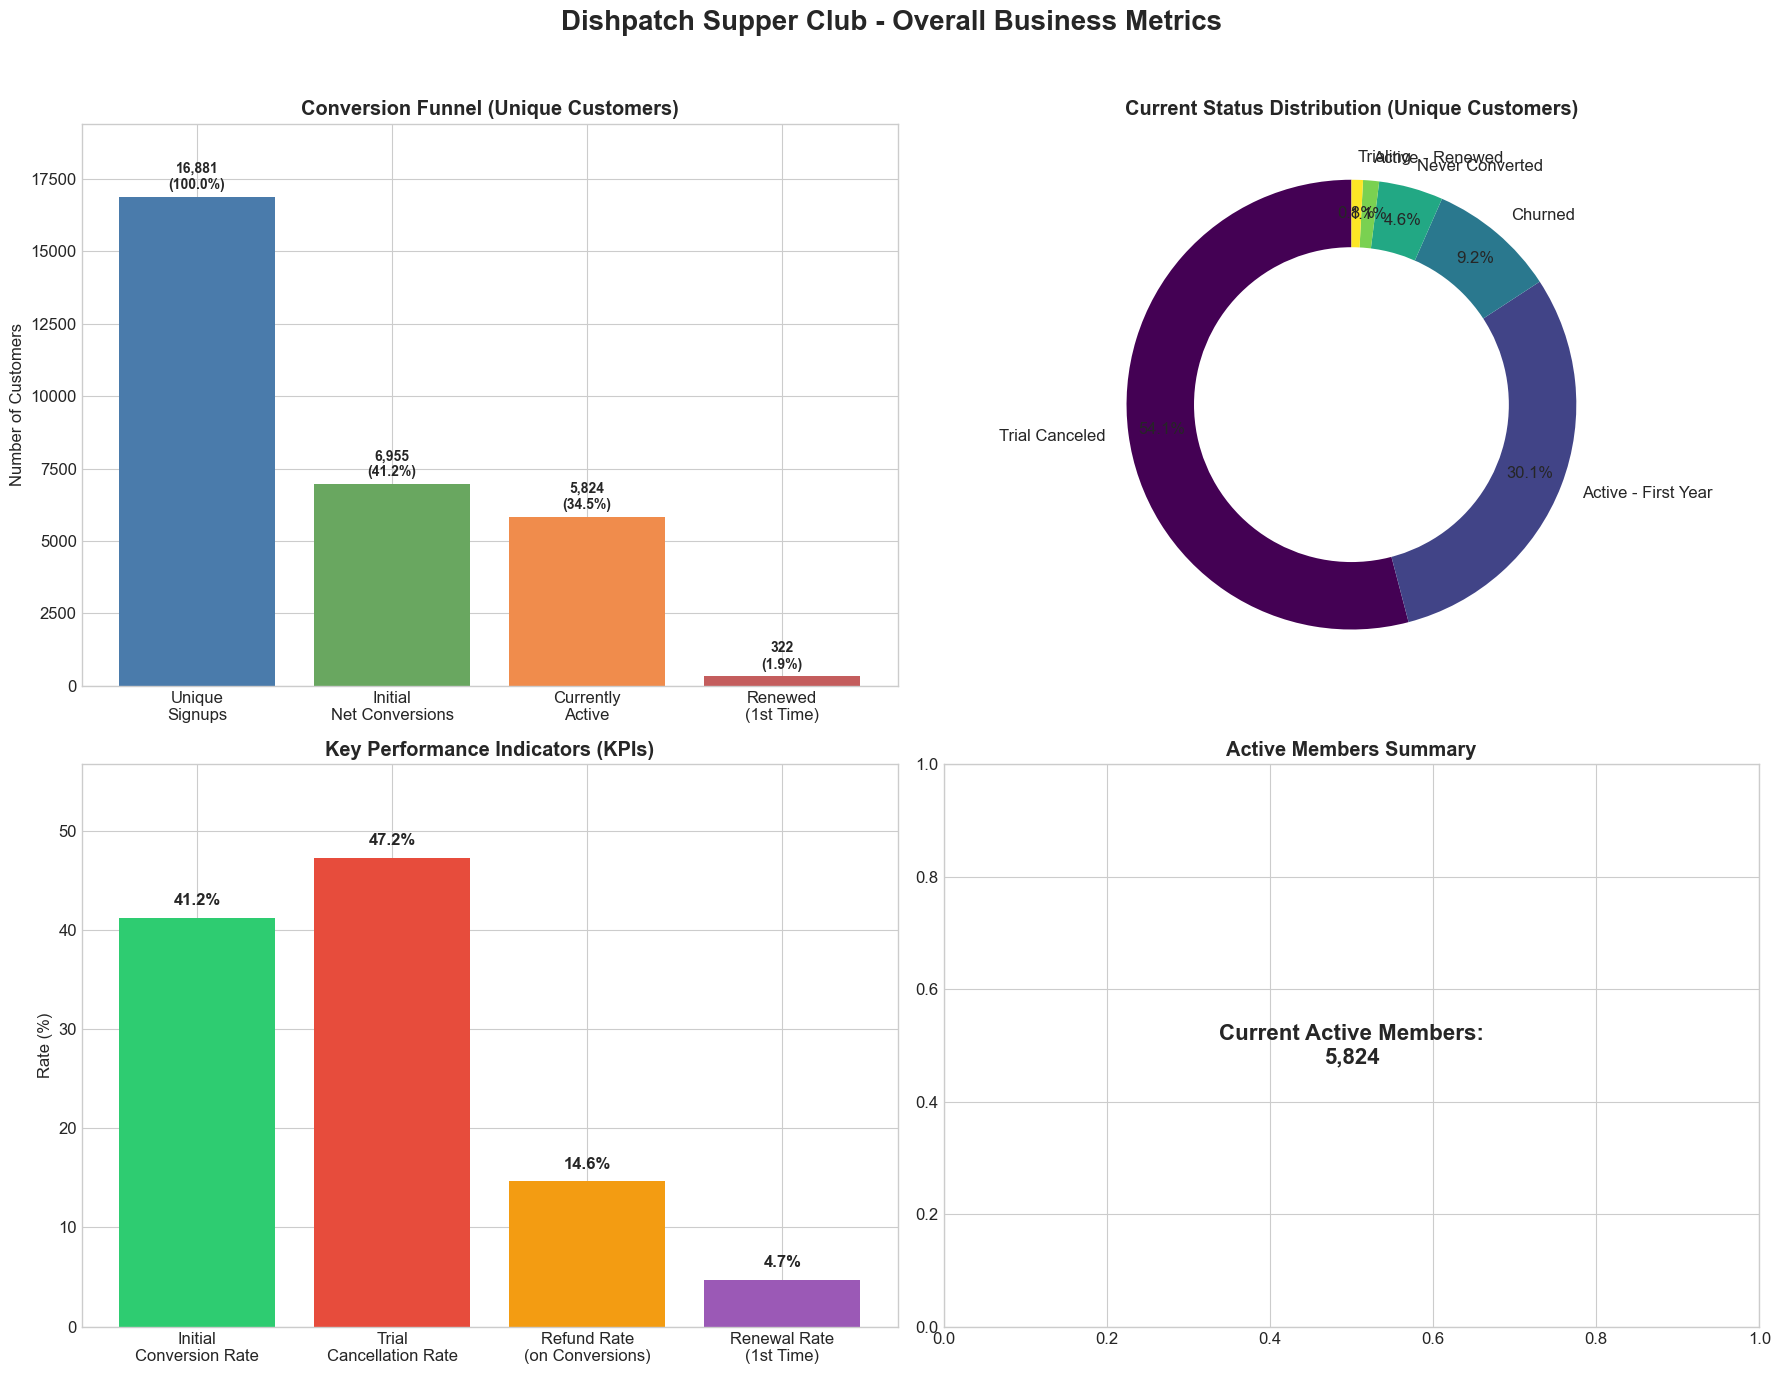

In [ ]:
create_improved_visualizations()

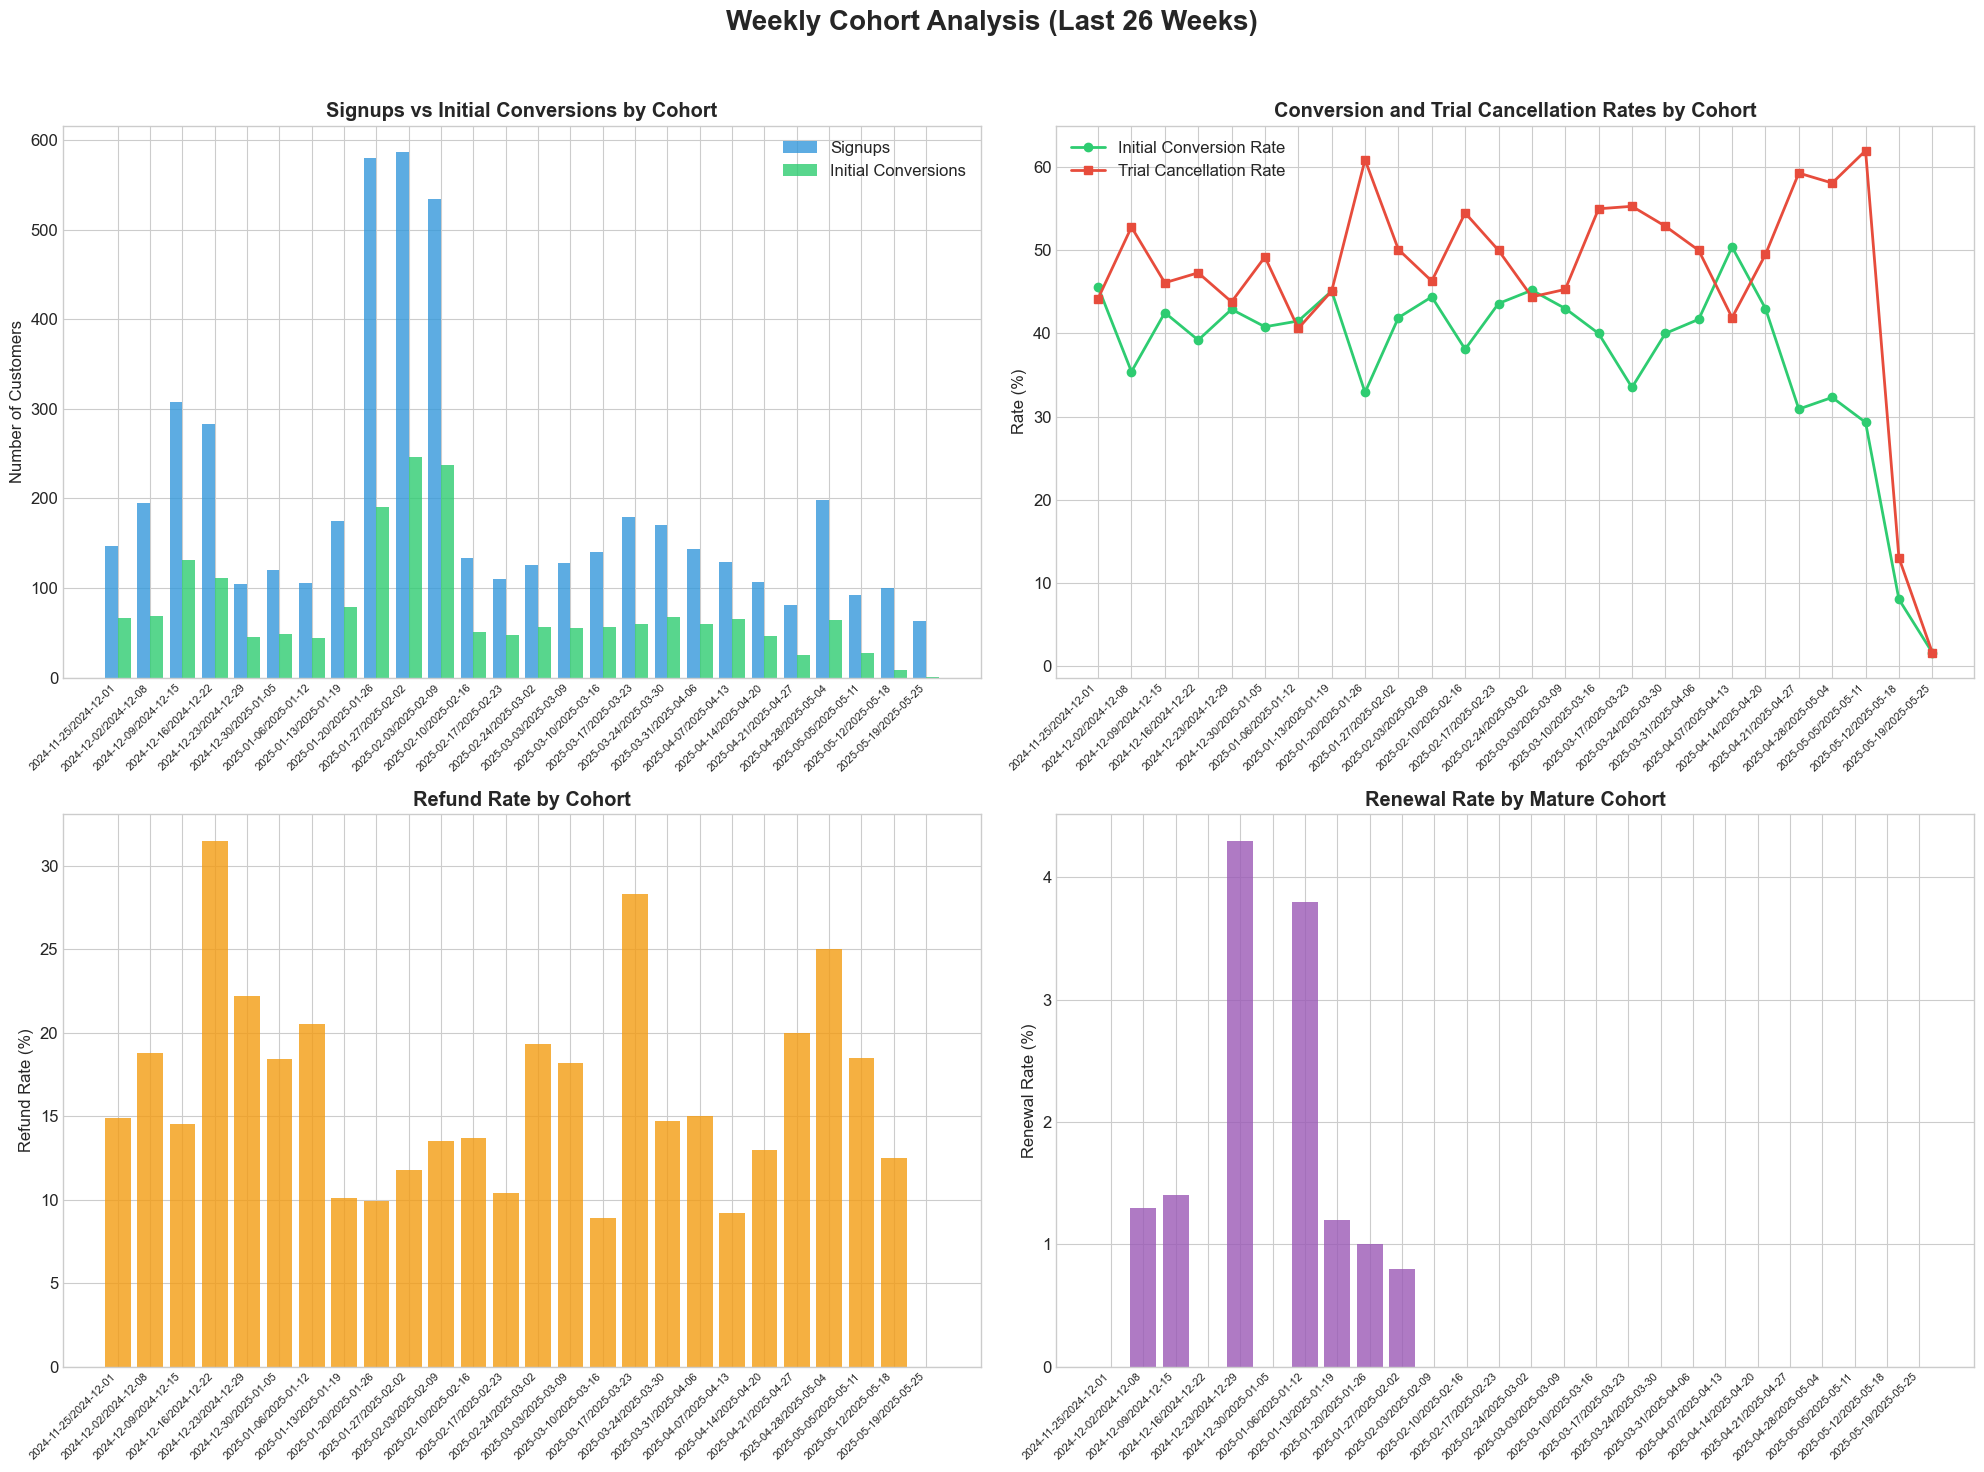

In [ ]:
create_cohort_analysis()

In [521]:
customer_df['current_status_agg'].value_counts()

Trial Canceled         9131
Active - First Year    5084
Churned                1552
Never Converted         781
Active - Renewed        194
Trialing                139
Name: current_status_agg, dtype: int64

In [522]:
customer_df['subscription_duration'].value_counts()

365    5254
10     4872
0      1093
366     688
375     352
       ... 
605       1
203       1
600       1
604       1
133       1
Name: subscription_duration, Length: 376, dtype: int64

In [523]:
customer_df[customer_df['subscription_duration'] == 976]
analysis_df[analysis_df['customer_name'] == 'Customer1022']


,id,customer_id,customer_name,status,Cancellation Reason,created_utc,start_utc,start_date_utc,current_period_start_utc,current_period_end_utc,...,paid_after_trial,is_trial_cancellation,is_refund,is_currently_trialing,real_duration,period_duration,trial_duration,unknown_period,only_trial,subscription_duration
12271,sub_1OsNTZCZ9aYYH5wiSpBdmKaF,cus_Phn31vxx4dQUvn,Customer1022,canceled,cancellation_requested,2024-03-09 10:50:00+00:00,2025-03-17 15:10:00+00:00,2024-03-09 10:50:00+00:00,2024-03-19 10:50:00+00:00,2025-03-19 10:50:00+00:00,...,True,False,False,False,365,365,10.0,10,False,365
7845,sub_1Q0QGeCZ9aYYH5wiaR3uwhlr,cus_OnEShcQu3BuHkj,Customer1022,canceled,cancellation_requested,2024-09-18 15:58:00+00:00,2024-09-18 15:58:00+00:00,2024-09-18 15:58:00+00:00,2024-09-18 15:58:00+00:00,2025-09-18 15:58:00+00:00,...,False,True,False,False,246,365,NaN,0,False,246
1079,sub_1R9knsCZ9aYYH5wiWxR1UQRA,cus_Phn31vxx4dQUvn,Customer1022,active,NaN,2025-04-03 10:15:00+00:00,2025-04-03 10:15:00+00:00,2025-04-03 10:15:00+00:00,2025-04-03 10:15:00+00:00,2026-04-03 10:15:00+00:00,...,True,False,False,False,365,365,NaN,0,False,365


In [524]:
analysis_df['subscription_duration'].value_counts()#.head(50)

10     6592
365    6062
0      1330
366     789
6       329
       ... 
303       1
214       1
285       1
327       1
291       1
Name: subscription_duration, Length: 265, dtype: int64

In [525]:
364
analysis_df[analysis_df['subscription_duration'] > 364]

,id,customer_id,customer_name,status,Cancellation Reason,created_utc,start_utc,start_date_utc,current_period_start_utc,current_period_end_utc,...,paid_after_trial,is_trial_cancellation,is_refund,is_currently_trialing,real_duration,period_duration,trial_duration,unknown_period,only_trial,subscription_duration
20432,sub_1NuBVGCZ9aYYH5wiA70QeS93,cus_OhagJTEOs7LZLk,Customer17737,active,NaN,2023-09-25 09:54:00+00:00,2023-09-25 09:54:00+00:00,2023-09-25 09:54:00+00:00,2024-10-25 09:54:00+00:00,2025-10-25 09:54:00+00:00,...,True,False,False,False,365,365,30.0,396,False,365
20427,sub_1NuCaDCZ9aYYH5wiT30q63rA,cus_OhbnOqt7eV3DHa,Customer17734,canceled,cancellation_requested,2023-09-25 11:04:00+00:00,2024-09-24 10:25:00+00:00,2023-09-25 11:04:00+00:00,2023-10-25 11:04:00+00:00,2024-10-25 11:04:00+00:00,...,True,False,False,False,366,366,30.0,30,False,366
20426,sub_1NuCqECZ9aYYH5wiRk14n0G1,cus_Ohc4lazRKnDFZ3,Customer17733,active,NaN,2023-09-25 11:20:00+00:00,2023-09-25 11:20:00+00:00,2023-09-25 11:20:00+00:00,2024-10-25 11:20:00+00:00,2025-10-25 11:20:00+00:00,...,True,False,False,False,365,365,30.0,396,False,365
20425,sub_1NuEHwCZ9aYYH5wiNwyhXtU2,cus_OhdZKUNDUARcWt,Customer17732,active,NaN,2023-09-25 12:53:00+00:00,2023-09-25 12:53:00+00:00,2023-09-25 12:53:00+00:00,2024-10-25 12:53:00+00:00,2025-10-25 12:53:00+00:00,...,True,False,False,False,365,365,30.0,396,False,365
20424,sub_1NuEWrCZ9aYYH5wiLHqOPgup,cus_OhdoK41SP2MMJ2,Customer17731,canceled,cancellation_requested,2023-09-25 13:08:00+00:00,2024-09-26 11:12:00+00:00,2023-09-25 13:08:00+00:00,2023-10-25 13:08:00+00:00,2024-10-25 13:08:00+00:00,...,True,False,False,False,366,366,30.0,30,False,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,sub_1RQXPlCZ9aYYH5wiUfGCEAdW,cus_RSV2R19DHU3jgw,Customer70,active,NaN,2025-05-19 17:23:00+00:00,2025-05-19 17:23:00+00:00,2025-05-19 17:23:00+00:00,2025-05-19 17:23:00+00:00,2026-05-19 17:23:00+00:00,...,True,False,False,False,365,365,NaN,0,False,365
60,sub_1RQZjQCZ9aYYH5winJZZQabF,cus_OnETa7vmJUoE0w,Customer61,active,NaN,2025-05-19 19:52:00+00:00,2025-05-19 19:52:00+00:00,2025-05-19 19:52:00+00:00,2025-05-19 19:52:00+00:00,2026-05-19 19:52:00+00:00,...,True,False,False,False,365,365,NaN,0,False,365
53,sub_1RQkH6CZ9aYYH5wigCxVmGgu,cus_Q3x455tQRv5MuX,Customer54,active,NaN,2025-05-20 07:07:00+00:00,2025-05-20 07:07:00+00:00,2025-05-20 07:07:00+00:00,2025-05-20 07:07:00+00:00,2026-05-20 07:07:00+00:00,...,True,False,False,False,365,365,NaN,0,False,365
33,sub_1RRARPCZ9aYYH5wiCQT2Dlkd,cus_QHo0AQ9O78eogO,Customer34,active,NaN,2025-05-21 11:04:00+00:00,2025-05-21 11:04:00+00:00,2025-05-21 11:04:00+00:00,2025-05-21 11:04:00+00:00,2026-05-21 11:04:00+00:00,...,True,False,False,False,365,365,NaN,0,False,365


In [526]:
analysis_df[analysis_df['customer_name'] == 'Customer10007']

,id,customer_id,customer_name,status,Cancellation Reason,created_utc,start_utc,start_date_utc,current_period_start_utc,current_period_end_utc,...,paid_after_trial,is_trial_cancellation,is_refund,is_currently_trialing,real_duration,period_duration,trial_duration,unknown_period,only_trial,subscription_duration
11156,sub_1P9TwUCZ9aYYH5wiEl1QAusA,cus_PzSskhHfbTqUHS,Customer10007,canceled,NaN,2024-04-25 15:10:00+00:00,2024-04-25 15:10:00+00:00,2024-04-25 15:10:00+00:00,2025-05-05 15:10:00+00:00,2026-05-05 15:10:00+00:00,...,False,False,False,False,365,365,10.0,375,False,365
